In [1]:
import pandas as pd
import os.path as op
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import seaborn as sns
import os
from numrisk.utils.data import Subject

bids_folder = '/Volumes/mrenkeED/data/ds-dnumrisk'
subs= [int(f[4:]) for f in listdir(bids_folder) if f[0:3] == 'sub']
pati_save = '/Users/mrenke/data/ds-dnumrisk/interim_sum_data'

target_folder = op.join(bids_folder, 'derivatives', 'cogmodels')
subjects = [Subject(sub, bids_folder) for sub in subs]

group_mapping = pd.read_csv('/Users/mrenke/data/ds-dnumrisk/interim_sum_data/group_assignment_sub1-42.csv').set_index('subject')


# Generate SDs - fit model

In [2]:
from bauer.models import MagnitudeComparisonModel
import arviz as az

target_accept = 0.9
burnin=1000
samples=1000

### shared perceptual noise - model fit (full data)
(analysis at bottom)

In [4]:
# single, for model-vis
from pymc import model_graph # needs graphviz which is only installed in behav_fit2 !

split_data = 'full'
runs = range(1,7)

memory_model='shared_perceptual_noise' # 'independant'
fit_prior = True
behavior = [s.get_behavior_magjudge(runs = runs) for s in subjects]
behavior = pd.concat(behavior).sort_index(0)

df = behavior.dropna()
df['choice'] = df['chose_n2']

model = MagnitudeComparisonModel(df, fit_prior=True,fit_seperate_evidence_sd = True, memory_model=memory_model)
model.build_estimation_model()
#model_graph.model_to_graphviz(model=model.estimation_model)

model.build_estimation_model()
trace = model.sample(burnin, samples, target_accept=target_accept)

fit_prior_ = 'fit' if fit_prior else 'obj'
evisd_ = memory_model
fn = op.join(target_folder, f'model-{split_data}_prior-{fit_prior_}_evisd-{evisd_}_trace.netcdf')
az.to_netcdf(trace,fn)



/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_2866/2871546834.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  behavior = pd.concat(behavior).sort_index(0)
/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_2866/2871546834.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['choice'] = df['chose_n2']
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [perceptual_noise_sd_mu_untransformed, perceptual_noise_sd_sd, perceptual_noise_sd_offset, memory_noise_sd_mu_untransformed, memory_noise_sd_sd, memory_noise_sd_offset, prior_mu_mu, prior_mu_sd, prior_mu_offset, prior_sd_mu_untransformed, 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 161 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


'/Volumes/mrenkeED/data/ds-dnumrisk/derivatives/cogmodels/model-full_prior-fit_evisd-shared_perceptual_noise_trace.netcdf'

### independant noise - loop with halfdata variants

In [ ]:
# loop 

fit_prior = False
evisd = False # fit_seperate_evidence_sd

data_variants = ['full', 'run_123', 'run_456'] #

for split_data in data_variants:
    if split_data == 'full':
        runs = range(1, 7)
    if split_data == 'run_123':
        runs = range(1, 4)
    elif split_data == 'run_456':
        runs = range(4,7)

    behavior = [s.get_behavior_magjudge(runs = runs) for s in subjects]
    df =  pd.concat(behavior).sort_index(0).dropna()
    df['choice'] = df['chose_n2']

    model = MagnitudeComparisonModel(df, fit_prior=fit_prior, fit_seperate_evidence_sd = evisd )
    model.build_estimation_model()
    trace = model.sample(burnin, samples, target_accept=target_accept)

    fit_prior_ = 'fit' if fit_prior else 'obj'
    evisd_ = 'sep' if evisd else 'same'
    fn = op.join(target_folder, f'model-{split_data}_prior-{fit_prior_}_evisd-{evisd_}_trace.netcdf')
    az.to_netcdf(trace,fn)
    print(f'saved to {fn}')
    

In [10]:
# extract evidence sd from trace

from bauer.utils.math import softplus_np

data_variants = ['full', 'run_123', 'run_456']
key = ''#_untransformed'# _offset

df_sds = []
for split_data in data_variants:
    #idata =  az.from_netcdf(op.join(target_folder, f'model-{split_data}_trace.netcdf'))
    idata =  az.from_netcdf(op.join(target_folder, f'model-{split_data}_prior-{fit_prior_}_evisd-{evisd_}_trace.netcdf'))
    #evidence_sd = pd.concat((idata.posterior['n1_evidence_sd_mu'].to_dataframe(), (idata.posterior['n2_evidence_sd_mu'].to_dataframe())), axis=1)
    evidence_sd = pd.concat((idata.posterior[f'n1_evidence_sd{key}'].to_dataframe(), (idata.posterior[f'n2_evidence_sd{key}'].to_dataframe())), axis=1)
    evidence_sd.columns.name = 'parameter'
    evidence_sd = evidence_sd.stack().to_frame('value')
    evidence_sd['Noise'] = evidence_sd.index.get_level_values('parameter').map({f'n1_evidence_sd{key}':'n1', f'n2_evidence_sd{key}':'n2'})
    evidence_sd = evidence_sd.set_index('Noise', append=True)
    evidence_sd['value_softpl'] = softplus_np(evidence_sd['value'])
    df_sds.append(evidence_sd.groupby(['subject','Noise'])['value_softpl'].mean()) # 


df_sds = pd.concat(df_sds, keys=data_variants, names=['data','subject','order']).to_frame('sd')

df_sds.to_csv(op.join(pati_save, f'sds_sub1-42_data-variants_prior-{fit_prior_}_evisd-{evisd_}.csv'))

In [12]:
# for fit_seperate_evidence_sd = False

from bauer.utils.math import softplus_np

df_sds = []
for split_data in data_variants:
    idata =  az.from_netcdf(op.join(target_folder, f'model-{split_data}_prior-{fit_prior_}_evisd-{evisd_}_trace.netcdf'))
    evidence_sd = idata.posterior[f'evidence_sd'].to_dataframe()
    evidence_sd['value_softpl'] = softplus_np(evidence_sd['evidence_sd'])
    df_sds.append(evidence_sd.groupby(['subject'])['value_softpl'].mean())

df_sds = pd.concat(df_sds, keys=data_variants, names=['data','subject']).to_frame('sd')

df_sds.to_csv(op.join(pati_save, f'sds_sub1-42_data-variants_prior-{fit_prior_}_evisd-{evisd_}.csv'))


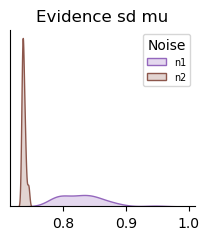

In [12]:
# should to this with the group level
temp = df_sds.xs('run_123',0,'data')
fac = sns.FacetGrid(temp.reset_index(), hue='order', palette=sns.color_palette()[4:], aspect=1.1, height=2.5)
fac.map(sns.kdeplot, 'sd', fill=True)
fac.set(xlabel=None, ylabel=None, yticks=[])
plt.title('Evidence sd mu')
plt.legend(title='Noise',loc='upper right',fontsize='x-small')


# comp. with r_decoding
## load in SDs

In [2]:
#fit_seperate_evidence_sd == True

evisd_ = 'sep'
noise = 'n1'
fit_prior_ = 'fit'
df_rs = pd.read_csv(op.join(pati_save, 'rs_sub1-42_data-variants.csv'))

df_sds = pd.read_csv(op.join(pati_save, f'sds_sub1-42_data-variants_prior-{fit_prior_}_evisd-sep.csv'))
df_sds = df_sds.set_index(['data','subject','order'])

df_comb = df_sds.xs(noise,0,'order').join(df_rs.set_index(['data','subject']))
df_comb = df_comb.join(group_mapping).set_index('group',append=True)

evisd_ = f'{evisd_} - {noise}'


In [15]:
# fit_seperate_evidence_sd == False
fit_prior_ = 'obj'
evisd_ = 'same'
df_rs = pd.read_csv(op.join(pati_save, 'rs_sub1-42_data-variants.csv'))

df_sds = pd.read_csv(op.join(pati_save, f'sds_sub1-42_data-variants_prior-{fit_prior_}_evisd-same.csv')).set_index(['data','subject'])

df_comb = df_sds.join(df_rs.set_index(['data','subject']))


Text(0.5, 1.0, 'data: full, \n prior: fit, \n evi-sd: sep - n1, \n r=0.11, p= 0.52503')

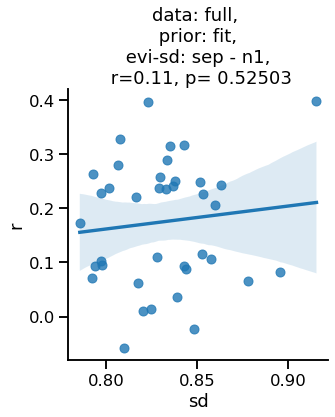

In [23]:
import pingouin 
sns.set_context('talk')
split_data = 'full'
temp = df_comb.xs(split_data,0,'data') # .xs(0,0,'group') --> but still no sign. correlation

var1 = 'sd' #'run_456' # 
var2 = 'r'
cor = pingouin.corr(temp[var1],temp[var2])
r_ = np.round(cor['r'][0], 2)
p = np.round(cor['p-val'][0], 5)

sns.lmplot(data=temp, x=var1,y=var2) #, hue='group'
plt.title(f'data: {split_data}, \n prior: {fit_prior_}, \n evi-sd: {evisd_}, \n r={r_}, p= {p}') 

## test retest reliability

In [12]:
import pingouin

noise_s = ['n1', 'n2']
data_variants = ['full', 'run_123', 'run_456']

for noise in noise_s:
    for split_data in data_variants:

        df_sd = df_sds.xs(noise,0,'order')['sd'].unstack('data')
        trr = pingouin.cronbach_alpha(data=df_sd.drop(split_data,axis=1))
        print(f'{noise}, {split_data}-removed, {np.round(trr[0])}')

n1, full-removed, 0.57
n1, run_123-removed, 0.86
n1, run_456-removed, 0.93
n2, full-removed, 0.23
n2, run_123-removed, 0.83
n2, run_456-removed, 0.8


## posterior parameters (general - full data)

In [2]:
import arviz as az
from bauer.utils.math import softplus_np

fit_prior_ = 'fit'
evisd_ = 'sep'
split_data = 'full'

trace =  az.from_netcdf(op.join(target_folder, f'model-{split_data}_prior-{fit_prior_}_evisd-{evisd_}_trace.netcdf'))


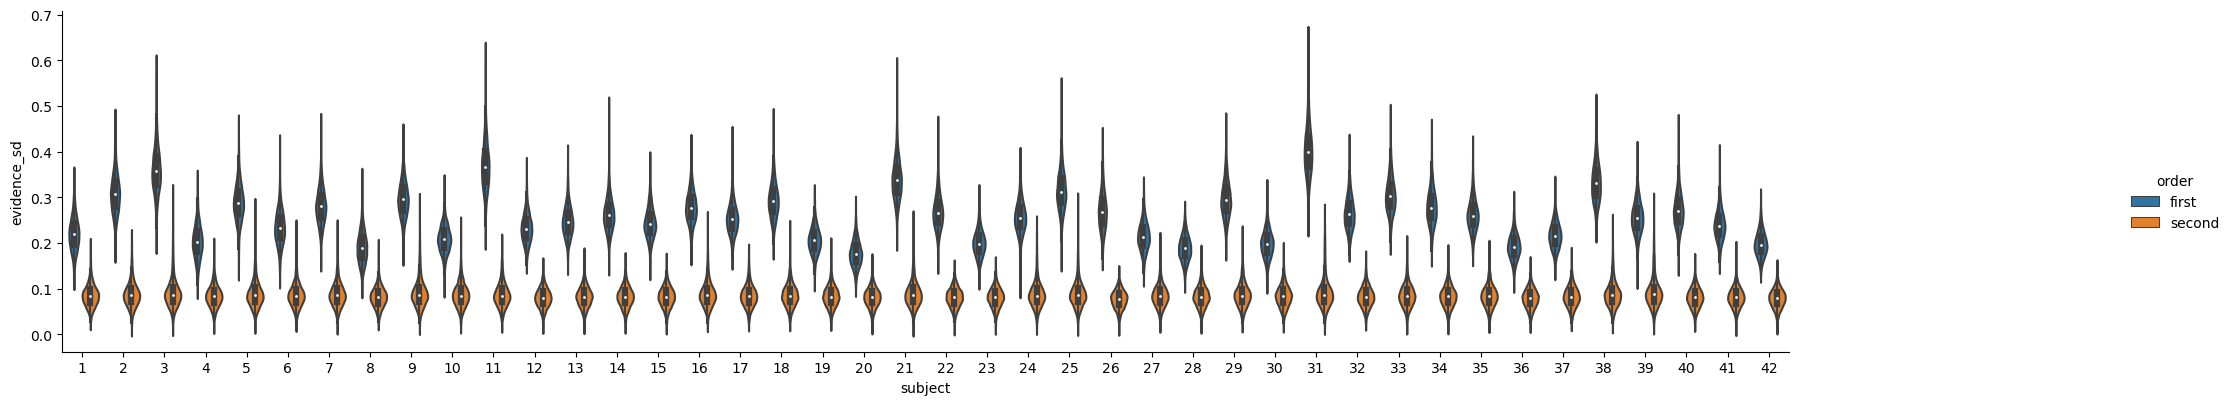

In [3]:
evidence_sd1 = trace.posterior['n1_evidence_sd'].to_dataframe()
evidence_sd2 = trace.posterior['n2_evidence_sd'].to_dataframe()

# evidence_sd = evidence_sd1.join(evidence_sd2)
evidence_sd = pd.concat((evidence_sd1['n1_evidence_sd'], evidence_sd2['n2_evidence_sd']),
keys=['first', 'second'], names=['order'], axis=0).to_frame('evidence_sd')

index_names = evidence_sd.index.names
evidence_sd.reset_index(inplace=True)
evidence_sd['subject'] = pd.Categorical(evidence_sd['subject'])
evidence_sd.set_index(keys=index_names, inplace=True)

fac = sns.catplot(x='subject', hue='order', y= 'evidence_sd', data=evidence_sd.reset_index(), kind='violin')

fac.fig.set_size_inches(25., 4)

In [14]:
temp = evidence_sd.groupby(['order','subject']).mean()
temp = temp.join(group_mapping)
temp['group']= np.where(temp['group'] == 0, 'control', 'dyscalc')


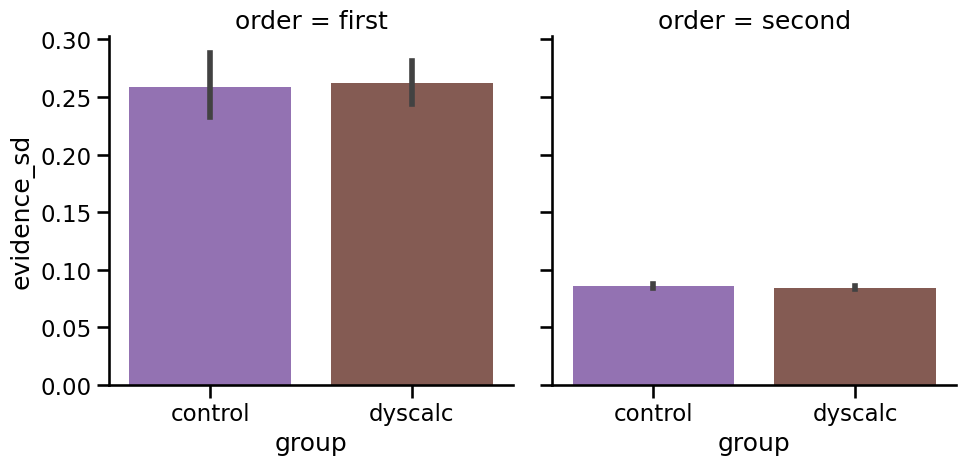

In [18]:
sns.set_context('talk')

palette = sns.color_palette()[4:]
sns.catplot(data =temp.reset_index() ,x='group',y='evidence_sd',kind='bar', col='order', palette = palette)

In [8]:
temp

evidence_sd    group
order  subject                      
first  1           0.220807  control
       2           0.309344  dyscalc
       3           0.359117  control
       4           0.203874  dyscalc
       5           0.289312  control
...                     ...      ...
second 38          0.087988  dyscalc
       39          0.091470  dyscalc
       40          0.081085  dyscalc
       41          0.081035  dyscalc
       42          0.079358  dyscalc

[84 rows x 2 columns]

## shared perceptual noise - version

In [8]:
idata = az.from_netcdf(op.join(target_folder, 'model-full_prior-fit_evisd-shared_perceptual_noise_trace.netcdf'))

In [10]:
memory = idata.posterior['memory_noise_sd'].to_dataframe()
perceptual = idata.posterior['perceptual_noise_sd'].to_dataframe()

evidence_sd = pd.concat((memory['memory_noise_sd'], perceptual['perceptual_noise_sd']),
keys=['memory', 'perceptual'], names=['noise'], axis=0).to_frame('evidence_sd')

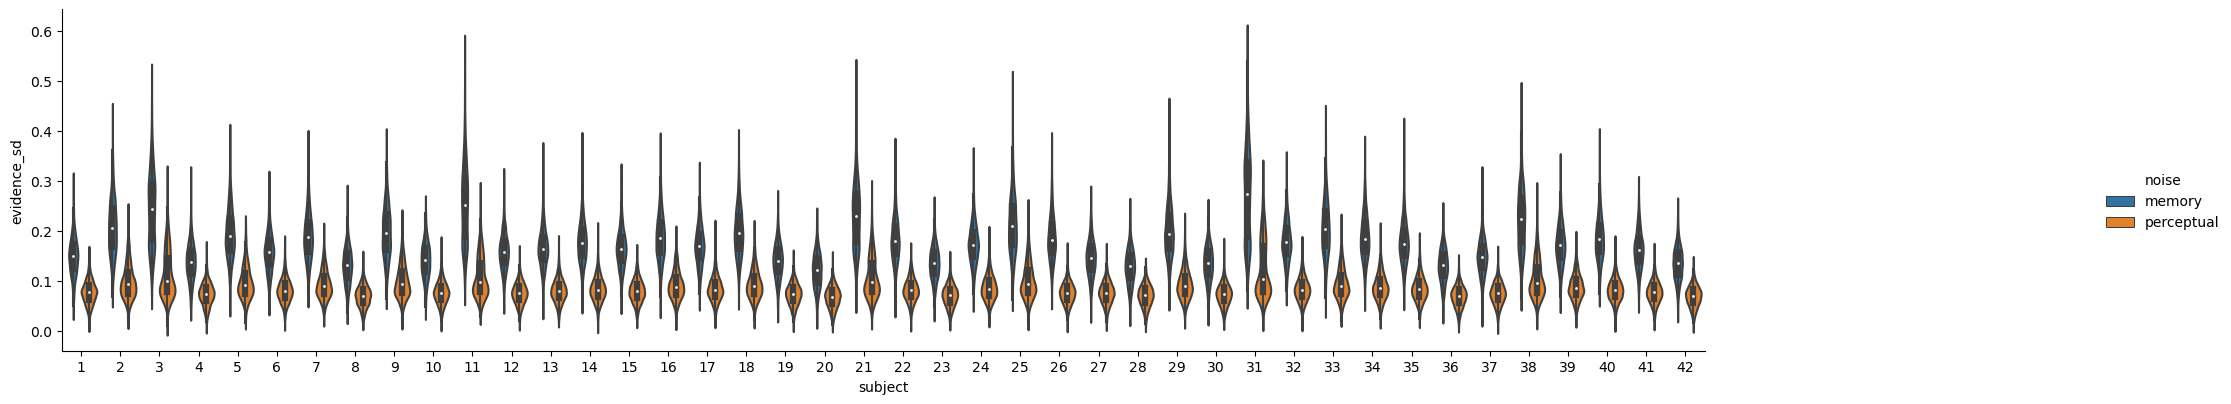

In [12]:
index_names = evidence_sd.index.names
evidence_sd.reset_index(inplace=True)
evidence_sd['subject'] = pd.Categorical(evidence_sd['subject'])
evidence_sd.set_index(keys=index_names, inplace=True)

fac = sns.catplot(x='subject', hue='noise', y= 'evidence_sd', data=evidence_sd.reset_index(), kind='violin')

fac.fig.set_size_inches(25., 4)

In [18]:
temp = evidence_sd.groupby(['noise','subject']).mean()
temp = temp['evidence_sd'].unstack('noise')
temp.head()

noise,memory,perceptual
subject,,
1,0.148994,0.077321
2,0.207777,0.097922
3,0.241734,0.112770
4,0.137878,0.073620
5,0.194289,0.096313


In [14]:
df_rs = pd.read_csv(op.join(pati_save, 'rs_sub1-42_data-variants.csv'))
df_rs = df_rs.set_index(['data','subject']).xs('full',0,'data')

df_comb = temp.join(df_rs)

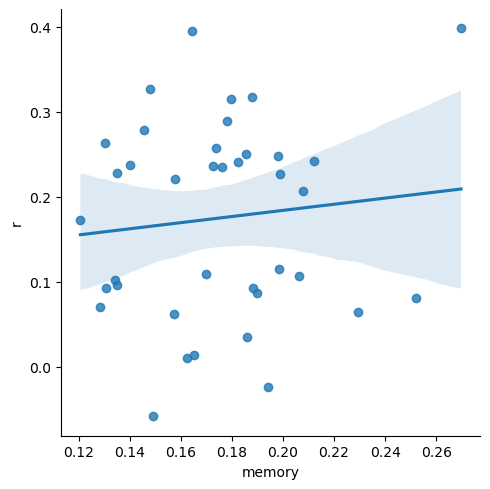

In [26]:
var1 = 'memory' #'run_456' # 
var2 = 'r'

sns.lmplot(data=df_comb, x=var1,y=var2) #, hue='group'


In [ ]:
cor = pingouin.corr(temp[var1],temp[var2])
r_ = np.round(cor['r'][0], 2)
p = np.round(cor['p-val'][0], 5)
plt.title(f'data: {split_data}, \n prior: {fit_prior_}, \n evi-sd: {evisd_}, \n r={r_}, p= {p}') 